In [1]:
train_data = './data/train'
train_labels = './data/train.csv'
val_data = './data/val'
val_labels = './data/val.csv'

In [2]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

2024-12-03 01:57:27.004708: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 01:57:27.126528: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX 6000 Ada Generation, compute capability 8.9


In [3]:
from utilities import GestureDataGenerator, plot_training_history, set_seed, get_callbacks, set_memorry_limit_for_tf
set_seed(seed=42)

mediapipe module not found. Skipping...
Random seed set to 42


In [4]:
load_fraction = 1.0             # Full data load
batch_size = 16                 # We are low on resources. We will go slow and steady.
image_size = (120, 120)

# Initialize the generator
train_generator = GestureDataGenerator(
    data_path=train_data,
    labels_csv=train_labels,
    batch_size=batch_size,
    image_size=image_size,
    # augmentations={
    #     'rotation': 5,       # Rotate up to ±5 degrees
    #     'brightness': True,  # Random brightness adjustment
    #     'contrast': True,    # Random contrast adjustment
    #     'blur': True         # Apply Gaussian blur
    # },    
    shuffle=True,
    load_fraction=load_fraction,
    debug=False,
    use_mediapipe=False,
)

val_generator = GestureDataGenerator(
    data_path=val_data,
    labels_csv=val_labels,
    batch_size=batch_size,
    image_size=image_size,
    augmentations=None,
    shuffle=False,
    load_fraction=1.0,
    debug=False,
    use_mediapipe=False,
)

# Get the first batch
X, y = train_generator[0]

# Print outputs
print("Input batch shape (X):", X.shape)  # Expected shape: (batch_size, sequence_length, 224, 224, 3)
print("Labels batch shape (y):", y.shape)  # Expected shape: (batch_size, num_classes)
print("First label in batch (one-hot):", y[0])

42 batches created, each of size 16, with 663 sequences of 30 images each. Use MediaPipe: False
7 batches created, each of size 16, with 100 sequences of 30 images each. Use MediaPipe: False
Input batch shape (X): (16, 30, 120, 120, 3)
Labels batch shape (y): (16, 5)
First label in batch (one-hot): [0. 0. 0. 1. 0.]


In [5]:
# Define parameters
sequence_length = train_generator.sequence_length                 # Frames per video (from generator)
image_size = train_generator.image_size                           # Image size (height, width)
num_classes = train_generator.num_classes                         # Number of gesture classes
input_shape = (sequence_length, image_size[0], image_size[1], 3)  # Conv3D input shape

In [6]:
from tensorflow.keras import layers, models, regularizers

# Define the model
model = models.Sequential([
    # Input layer
    layers.Input(shape=input_shape),  # Input shape: (timesteps, height, width, channels)

    # Smaller CNN layers for feature extraction
    layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),

    layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),

    layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),

    # Global average pooling to reduce parameters
    layers.TimeDistributed(layers.GlobalAveragePooling2D()),

    # RNN layer for temporal modeling
    layers.Bidirectional(layers.GRU(32, return_sequences=False, recurrent_activation='sigmoid')),  # cuDNN-compatible configuration

    # Fully connected layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.4),

    # Output layer
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Print the model summary
model.summary()

2024-12-03 01:57:29.343811: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 01:57:29.490154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44826 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)   1

In [7]:
model_save_location = 'best-models/Conv2D+GRU.keras'

In [8]:
checkpoint_callback, reduce_lr_callback, early_stopping_callback = get_callbacks(
    filepath = model_save_location, 
    save_best_only=True)

Epoch 1/50


2024-12-03 01:57:33.841030: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


42/42 [==============================] - 29s 625ms/step - loss: 2.0571 - accuracy: 0.3650 - val_loss: 2.1640 - val_accuracy: 0.1600 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 26s 616ms/step - loss: 1.7069 - accuracy: 0.4721 - val_loss: 2.3589 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 26s 621ms/step - loss: 1.5055 - accuracy: 0.5460 - val_loss: 2.7323 - val_accuracy: 0.1900 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - 26s 611ms/step - loss: 1.3116 - accuracy: 0.6139 - val_loss: 2.9120 - val_accuracy: 0.1600 - lr: 0.0010
Epoch 5/50
42/42 [==============================] - 26s 614ms/step - loss: 1.2079 - accuracy: 0.6516 - val_loss: 2.7020 - val_accuracy: 0.1600 - lr: 0.0010
Epoch 6/50
42/42 [==============================] - ETA: 0s - loss: 1.1663 - accuracy: 0.6606
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
42/42 [==============================] - 27s 639ms/step - los

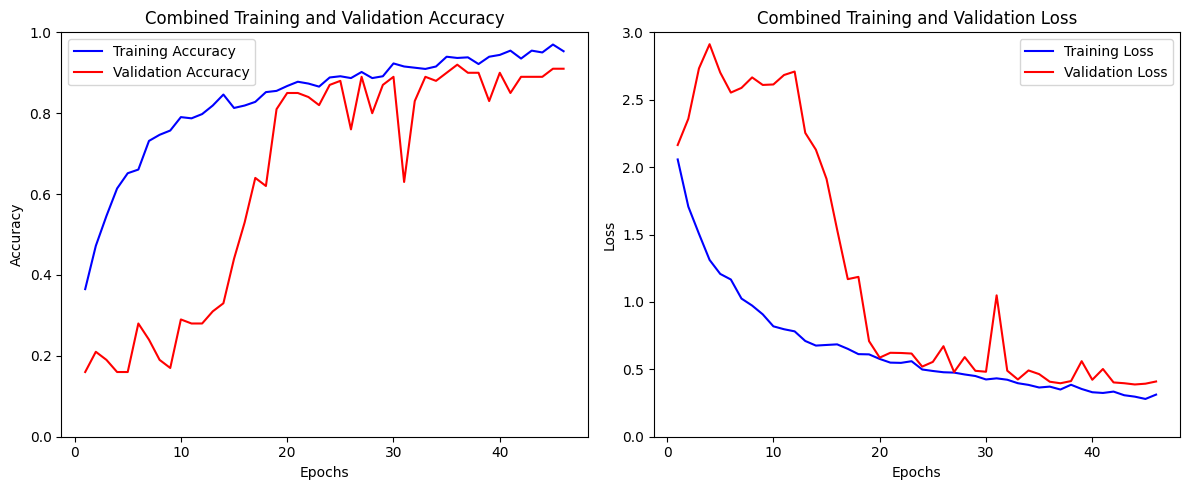

In [9]:
# Train the model
history_1 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1])

In [10]:
# model.load_weights(model_save_location)

# # Train the model for more epochs
# history_2 = model.fit(
#     x=train_generator,
#     validation_data=val_generator,
#     epochs=50,                  # Train for more epochs
#     initial_epoch=30,           # Start counting previous epochs
#     callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
#     verbose=1
# )

# plot_training_history(histories=[history_1, history_2])

In [11]:
# model.load_weights(model_save_location)

# # Train the model for more epochs
# history_3 = model.fit(
#     x=train_generator,
#     validation_data=val_generator,
#     epochs=50,                   # Train for more epochs
#     initial_epoch=30,            # Start counting previous epochs
#     callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
#     verbose=1
# )

# plot_training_history(histories=[history_1, history_2, history_3])

In [12]:
model.load_weights(model_save_location)

evaluation_results = model.evaluate(val_generator, verbose=1)

for metric, value in zip(model.metrics_names, evaluation_results):
    print(f"{metric}: {value:.4f}")

4/7 [================>.............] - ETA: 1s - loss: 0.4600 - accuracy: 0.8906

7/7 [==============================] - 4s 594ms/step - loss: 0.4081 - accuracy: 0.9200
loss: 0.4081
accuracy: 0.9200


In [13]:
model.load_weights(model_save_location)

evaluation_results = model.evaluate(train_generator, verbose=1)

for metric, value in zip(model.metrics_names, evaluation_results):
    print(f"{metric}: {value:.4f}")

42/42 [==============================] - 22s 521ms/step - loss: 0.2769 - accuracy: 0.9774
loss: 0.2769
accuracy: 0.9774
